# Model NEATM 余亮亮 修改 $\alpha, \phi$
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\alpha+\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$


# LS_NEATM
## import & define const

In [9]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import tqdm

#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9              #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
eta_guess = [1.2,0.7]
D_guess = [400,200000]
logf_guess = [1,0.1,1]
eta_piror = [0.5,2.8]
D_piror = [0,2500000]
Hv = 20
G = 0.15
Ndd = 10
lamdai = [12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

### Model_hhq

In [10]:
def neatm_ohhq(Ndd,eta,D,delta,dd,alpha,lamda,A):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = np.power((1-A)*Fsun/(eta*epsi*sigma*dd*dd),0.25)
    #print(f"Tss = {Tfit}\n")
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*np.power(np.cos(thei),0.25)*np.power(np.cos(phii),0.25)
            #print(f"Tss = {T-273}\n")
            integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
            summ = summ + dxdy*integral
    #print('hhq',delta)
    F = (epsi*np.power(D,2)*pi*h*cl*cl)*summ/(2*np.power(delta*au,2)*np.power(lamda,5))

    F = F*(lamda)**2/cl*1e29
    #print('hhq2',delta)
    return F
def Model_neatm_ohhq(theta,x,lamda):
    eta,D = theta
    
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    #print("neatm ",delta)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda1*1e-6,A)
    for i in range(int(nn/2),nn):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda2*1e-6,A)
        #print("neatm",i,'=',delta[i])
    #print('2',delta)
    return flux

### Model_jhx

In [11]:
#constants---------------------------------------------------------------------------
#emissivity:
epsi = 0.9
#stefan-boltzman:
sigmas = 5.67*10**(-8)
#solar constant:
f_solar = 1367.5
#planck constant:
h = 6.62607015 * 10 ** (-34)
#speed of light
c = 3.0 * 10 ** 8 
#boltzmann constant
kb = 1.380649 * 10 ** (-23)
#astronomical unit in unit of meter
au = 1.496 * 10 ** 11
def neatm_jhx(Ndd,dast,dao,alpha,Dia,wlenth,yita,A):
    #dast: distance from asteroid to Sun :d
    #dobs: distance from observer to Sun  :dd
    #dao:  distance from asteroid to observer :delta
    #alpha: solar phase
    #dia: diameter of asteroid
    #wlenth: wavelength
    #yita: beaming parameter
    #A: bond albedo
	
	T_ss = ((1 - A) * f_solar / epsi / yita / sigmas / dast ** 2) ** 0.25
	Nd = int(Ndd);#print(f'nd={Nd}')
	phi = np.zeros((Nd-1,1))
	theta = np.zeros((Nd-1,1))
	for i in range(0,Nd-1):#phi , theta is the angle from subsolar point
			phi[i] = -pi/2.0 + i * pi / Nd
			theta[i] = alpha-pi/2.0 + i * pi / Nd
	#nj = np.floor(((alpha - pi / 2.0) + pi / 2.0) / (pi / Nd)) 
	dphi, dtheta = (pi)/Nd,pi/Nd;#print(f'phi={phi};the={theta}')
	ss = dphi*dtheta;#print(f'ss={ss}')#dtheta*dphi
	wlenth = wlenth * 10 ** (-6)
	temp = np.zeros((len(phi),len(theta)))
	flux = 0.0
	flux_con = epsi * Dia ** 2 * pi  * h * c ** 2  / (wlenth ** 5)
	for j in range(0,len(phi)):
		for k in range(0,len(theta)):
			temp[j,k] = T_ss * abs(np.cos(theta[k])) ** 0.25 * abs(np.cos(phi[j])) ** 0.25;#print(f'tss:{T_ss}p{phi[j]}t{theta[k]}');print(f'temp:{temp[j,k]}e={np.exp(h * c / (wlenth * kb * temp[j,k])) - 1}')
			flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 ;#print(f'f={flux}')# obtain flux in unit of mjy
	return flux
def Model_neatm_jhx(theta,x,lamda):
    eta,D =theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    nn = len(delta)
    flux = np.zeros(nn)
    for i in range(0,int(nn/2)):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda1,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
    for i in range(int(nn/2),nn):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda2,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
        
    #print('hello',flux)
    return flux

## read data file

/tmp/ipykernel_346376/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_346376/3011063627.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 ;#print(f'f={flux}')# obtain flux in unit of mjy


[4.19314061 4.21550194 4.22386487 4.22397087 4.22874872 4.2419773
 4.24429707 4.26427762 4.68708917 4.71629431 4.73498265 4.7915769
 4.79783758 4.80368925 4.84322937 4.862727   4.87759729 4.88733249
 4.89244547 4.89596135 4.90165571 4.91030156 4.93671332 4.98626095
 4.99144705 4.99487287 5.00634165 5.01571208 5.04115    5.05039291
 5.06544971 5.07091346 5.07976287 5.08774536 5.09092687 5.10036992
 5.10585039 5.11070157 5.12069751 5.15564179 5.1650232  5.18521328
 5.19519685 5.19969038 5.22018433 5.27192137 5.31338111 5.33318803
 5.35374569 5.35374569 0.         6.12797535 6.16099483 6.17332059
 6.17351629 6.18055185 6.2000767  6.20347237 6.23301572 6.85471538
 6.89750958 6.92485431 7.00767343 7.01684851 7.02542696 7.08326479
 7.11176421 7.1334975  7.14771508 7.15519255 7.16029855 7.1686257
 7.18123946 7.21983824 7.29215474 7.29972732 7.30469564 7.32145473
 7.33510324 7.37221597 7.38566395 7.40761769 7.41559955 7.4284758
 7.4400807  7.44476535 7.4585138  7.46650739 7.47356926 7.48813266

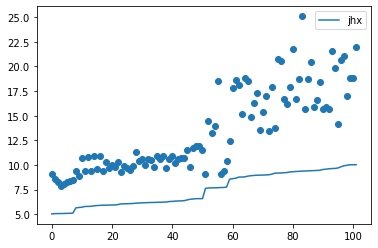

In [25]:
name = '2ev5'
obsec = np.loadtxt(f'ObsECs_{name}.txt')
#print(obsec)
obsdat = np.loadtxt(f'obs_{name}.txt')
#obstime  = np.loadtxt(f'fobs_{name}.txt')
#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#earth-sun
#print(delta_N)
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
y = obsdat
nt = np.arange(len(d_N))
plt.scatter(nt,y)
#delta_N,d_N,alpha_N = x
'''for i in np.arange(100,2000,50):
    theta = [0.2,i]
    flux = Model_neatm_hhq(theta,x=(delta_N,d_N,alpha_N))
    flux2 = Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N))
    print(i,flux[0],flux2[0])
for i in np.arange(0.1,2.4,0.1):
    theta = [i,456]
    flux = Model_neatm_hhq(theta,x=(delta_N,d_N,alpha_N))
    flux2 = Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N))
    print(i,flux[0],flux2[0])'''
theta = [2.8,200]
flux = Model_neatm_ohhq(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
flux2 = Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
x = (delta_N,d_N,alpha_N)
yerr = 0.1*y
#plt.plot(nt,flux,label = 'hhq')
plt.plot(nt,flux2,label = 'jhx')
print(flux,flux2)
plt.legend()


## define MCMC_function

In [13]:
def loss(cal,y,yerr):
    nn = len(y)
    return sum(((cal-y)/yerr)**2)/nn

In [34]:
#initial
eta_gss = [0.1,2.8,0.1]
D_gss = [200,500,1]
n_eta = int((eta_gss[1]-eta_gss[0])/eta_gss[2]+1)                     
n_D = int((D_gss[1]-D_gss[0])/D_gss[2]+1)
Ntime = n_eta*n_D         
print(f'It`s need {Ntime} setps',f'eta={n_eta} d={n_D}')

minloss = 10e6
nstep = 0
Di = D_gss[0]
for i in tqdm.tqdm(range(n_D)):
    etai = eta_gss[0]
    for j in tqdm.tqdm(range(n_eta), leave=False):
        flux = Model_neatm_jhx(theta=(etai,Di),x=x,lamda=lamdai)
        lossi = loss(flux,y,yerr)
        if lossi<minloss :
            minloss = lossi
            eta_fit = etai
            D_fit  = Di
            print(f'step {nstep} :loss = {lossi} eta = {eta_fit} D = {D_fit}')
        etai = etai + eta_gss[2]
        #print(etai)
        nstep = nstep + 1
    Di = Di + D_gss[2]


It`s need 8127 setps eta=27 d=301


  0%|          | 0/301 [00:00<?, ?it/s]/tmp/ipykernel_346376/3011063627.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 ;#print(f'f={flux}')# obtain flux in unit of mjy
  0%|          | 0/301 [00:00<?, ?it/s]


TypeError: 'float' object is not callable

In [21]:
#initial
eta_gss = [0.1,3,0.05]
D_gss = [200,500,2]
Neta = int((eta_gss[1]-eta_gss[0])/eta_gss[2])
ND = int((D_gss[1]-D_gss[0])/D_gss[2])
print(ND,Neta,lamdai)

150 57 [12, 22]


In [27]:
minloss = 1e10
etai = eta_gss[0]
Di = D_gss[0]
eta = etai
D = Di
for i in tqdm.tqdm(range(Neta)):
    for j in range(ND):
        thetai = [etai,Di]
        lossi = loss(Model_neatm_ohhq(thetai,x,lamdai),y,yerr)
        if lossi<minloss:
            miniloss = lossi
            eta = etai
            D = Di
            print(eta,D,lossi)
        Di = Di + D_gss[2]
    etai = etai + eta_gss[2]      
theta=[eta,D]   

  0%|          | 0/57 [00:00<?, ?it/s]/tmp/ipykernel_346376/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


0.1 200 2538.869359021829
0.1 202 2674.2262269914727
0.1 204 2814.485967387537
0.1 206 2959.7537859586605
0.1 208 3110.135940250193
0.1 210 3265.7397386893813
0.1 212 3426.6735397460893
0.1 214 3593.0467511618717
0.1 216 3764.969829241045
0.1 218 3942.5542781979807
0.1 220 4125.91264955548
0.1 222 4315.15854158965
0.1 224 4510.406598817147
0.1 226 4711.772511521038
0.1 228 4919.373015311975
0.1 230 5133.325890721622
0.1 232 5353.749962825626
0.1 234 5580.765100893654
0.1 236 5814.492218064242
0.1 238 6055.053271042505
0.1 240 6302.571259818782
0.1 242 6557.170227406542
0.1 244 6818.975259598143
0.1 246 7088.112484736869
0.1 248 7364.709073504258
0.1 250 7648.893238721178
0.1 252 7940.794235162033
0.1 254 8240.542359380779
0.1 256 8548.268949548044
0.1 258 8864.106385298564
0.1 260 9188.188087588047
0.1 262 9520.648518558943
0.1 264 9861.623181414354
0.1 266 10211.248620299652
0.1 268 10569.662420191142
0.1 270 10937.003206791365
0.1 272 11313.410646430513
0.1 274 11699.025445973695
0.1

  2%|▏         | 1/57 [00:09<09:02,  9.70s/it]

0.1 492 146596.62665426967
0.1 494 149090.97946123077
0.1 496 151616.61844718526
0.1 498 154173.8006989833
0.15000000000000002 500 96667.44824338527
0.15000000000000002 502 98295.46103294038
0.15000000000000002 504 99943.64790819003
0.15000000000000002 506 101612.1723130862
0.15000000000000002 508 103301.19834148999
0.15000000000000002 510 105010.89073717062
0.15000000000000002 512 106741.41489380476
0.15000000000000002 514 108492.93685497627
0.15000000000000002 516 110265.6233141753
0.15000000000000002 518 112059.64161479779
0.15000000000000002 520 113875.15975014506
0.15000000000000002 522 115712.34636342303
0.15000000000000002 524 117571.3707477415
0.15000000000000002 526 119452.40284611414
0.15000000000000002 528 121355.61325145779
0.15000000000000002 530 123281.17320659185
0.15000000000000002 532 125229.25460423774
0.15000000000000002 534 127200.02998701834
0.15000000000000002 536 129193.67254745847
0.15000000000000002 538 131210.3561279829
0.15000000000000002 540 133250.255220917

  4%|▎         | 2/57 [00:19<08:49,  9.63s/it]

0.15000000000000002 796 656065.549300306
0.15000000000000002 798 662801.3224097139
0.2 800 468795.70478643413
0.2 802 473595.8392771004
0.2 804 478432.5005664626
0.2 806 483305.87225613487
0.2 808 488216.1384050236
0.2 810 493163.48352932243
0.2 812 498148.09260251926
0.2 814 503170.1510553911
0.2 816 508229.84477600607
0.2 818 513327.360109722
0.2 820 518462.8838591885
0.2 822 523636.60328434553
0.2 824 528848.7061024245
0.2 826 534099.3804879456
0.2 828 539388.8150727213
0.2 830 544717.1989458532
0.2 832 550084.7216537358
0.2 834 555491.5732000514
0.2 836 560937.944045775
0.2 838 566424.0251091698
0.2 840 571950.0077657927
0.2 842 577516.083848489
0.2 844 583122.4456473946
0.2 846 588769.2859099362
0.2 848 594456.7978408308
0.2 850 600185.1751020858
0.2 852 605954.6118129991
0.2 854 611765.3025501596
0.2 856 617617.442347446
0.2 858 623511.2266960269
0.2 860 629446.8515443626
0.2 862 635424.5132982018
0.2 864 641444.4088205864
0.2 866 647506.7354318459
0.2 868 653611.690909602
0.2 87

  5%|▌         | 3/57 [00:28<08:38,  9.60s/it]

0.2 1092 1657841.9714632318
0.2 1094 1670150.7817165027
0.2 1096 1682527.7650210825
0.2 1098 1694973.171742925
0.25 1100 1282025.6392526147
0.25 1102 1291485.004386749
0.25 1104 1300996.4171329862
0.25 1106 1310560.0673155405
0.25 1108 1320176.145102822
0.25 1110 1329844.841007438
0.25 1112 1339566.34588619
0.25 1114 1349340.8509400783
0.25 1116 1359168.547714298
0.25 1118 1369049.6280982418
0.25 1120 1378984.284325496
0.25 1122 1388972.7089738504
0.25 1124 1399015.0949652826
0.25 1126 1409111.635565972
0.25 1128 1419262.5243862916
0.25 1130 1429467.955380813
0.25 1132 1439728.1228483024
0.25 1134 1450043.221431724
0.25 1136 1460413.4461182377
0.25 1138 1470838.9922391977
0.25 1140 1481320.0554701614
0.25 1142 1491856.8318308718
0.25 1144 1502449.517685278
0.25 1146 1513098.309741522
0.25 1148 1523803.4050519397
0.25 1150 1534565.0010130662
0.25 1152 1545383.2953656346
0.25 1154 1556258.4861945708
0.25 1156 1567190.771928998
0.25 1158 1578180.3513422357
0.25 1160 1589227.4235518011
0.2

  5%|▌         | 3/57 [00:36<11:00, 12.22s/it]

0.25 1338 2827827.028966217
0.25 1340 2844907.0632535936


KeyboardInterrupt: 

0.25 1340 10000000000.0


/tmp/ipykernel_346376/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


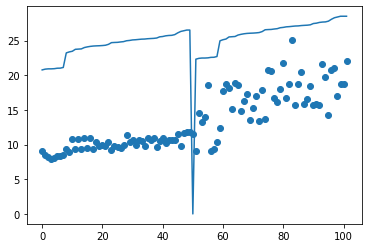

In [32]:
print(eta,D,minloss)  
plt.scatter(nt,y) 
plt.plot(nt,Model_neatm_ohhq([1.5,300],x,lamdai),label = 'jhx')  